# IoT Equipment Failure Prediction using Sensor data

In [349]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.svm import SVC

# Data

In [350]:
data = pd.read_csv('iot_sensor_dataset.csv')
data.head(10)

,footfall,atemp,selfLR,ClinLR,DoleLR,PID,outpressure,inpressure,temp,fail
0,0,7,7,1,6,6,36,3,1,1
1,190,1,3,3,5,1,20,4,1,0
2,31,7,2,2,6,1,24,6,1,0
3,83,4,3,4,5,1,28,6,1,0
4,640,7,5,6,4,0,68,6,1,0
5,110,3,3,4,6,1,21,4,1,0
6,100,7,5,6,4,1,77,4,1,0
7,31,1,5,4,5,4,21,4,1,0
8,180,7,4,6,3,3,31,4,1,0
9,2800,0,3,3,7,0,39,3,1,0


In [351]:
X = data.iloc[:,:9]
y = data.iloc[:,9]
train_x, test_x, train_y, test_y = train_test_split(X,y)

# Confusion_matrix

In [352]:
def confusion_matrix(actfail, predictfail):
  # Compute Confusion matrix
  print("Actual, Predicted Observations:  ",len(actfail), len(predictfail))
  # print(actfail, predictfail)
  anpn = 0
  anpy = 0
  aypn = 0
  aypy = 0
  
  for i in range(len(actfail)):
      if (actfail[i]==0 and predictfail[i]==0):
          anpn = anpn + 1
      elif (actfail[i]==0 and predictfail[i]==1):
          anpy = anpy + 1
      elif (actfail[i]==1 and predictfail[i]==0):
          aypn = aypn + 1
      else:
          aypy = aypy + 1
  # Confusoin matrix
  print ("--------------------------------------------")
  print ("Confusion Matrix")
  print ("--------------------------------------------")
  print ("              ", "Predicted N", "Predicted Y")
  print ("Actual N      ", anpn,"          ", anpy) 
  print ("Actual Y      ", aypn,"          ", aypy)
  print ("--------------------------------------------")
  print ("Total observations  :  ", anpn+anpy+aypn+aypy)
  print ("False Positives     :  ", anpy)
  print ("False Negatives     :  ", aypn)
  print ("Overall Accuracy    :  ", round((float(anpn+aypy)/float(anpn+anpy+aypn+aypy))*100, 2), "%")
  print ("Sensitivity/Recall  :  ", round((float(aypy)/float(aypn+aypy))*100, 2), "%")
  print ("Specificity         :  ", round((float(anpn)/float(anpn+anpy))*100, 2), "%")
  print ("Precision           :  ", round((float(aypy)/float(anpy+aypy))*100, 2), "%")
  print ("--------------------------------------------")

# ExtraTreesClassifier

Feature ranking:
1. feature 5 (0.467339)
2. feature 2 (0.166052)
3. feature 3 (0.118038)
4. feature 4 (0.062844)
5. feature 8 (0.043691)
6. feature 0 (0.042401)
7. feature 6 (0.037795)
8. feature 7 (0.031798)
9. feature 1 (0.030041)


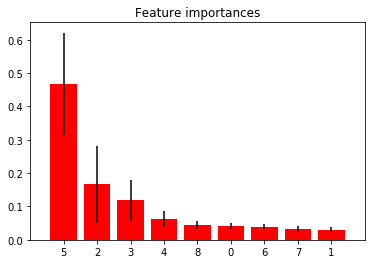

[0.04240099 0.03004099 0.16605247 0.11803829 0.06284406 0.46733893
 0.03779531 0.03179821 0.04369075]


In [343]:
forest = ExtraTreesClassifier(n_estimators=250,random_state=0)
forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()
print(forest.feature_importances_)

# http://rasbt.github.io/mlxtend/user_guide/feature_selection/ExhaustiveFeatureSelector/

# LogisticRegression

In [333]:
model = LogisticRegression()
efs1 = EFS(model, 
           min_features=1,
           max_features=9,
           scoring='accuracy',
           print_progress=True)

efs1 = efs1.fit(train_x, train_y)
print('Best accuracy score: %.2f' % efs1.best_score_)
print('Best subset (indices):', efs1.best_idx_)
print('Best subset (corresponding names):', efs1.best_feature_names_)

Features: 511/511

Best accuracy score: 0.91
Best subset (indices): (2, 3, 5, 8)
Best subset (corresponding names): ('selfLR', 'ClinLR', 'PID', 'temp')


In [340]:
X_train_efs = efs1.transform(train_x)
X_test_efs = efs1.transform(test_x)

# Fit the estimator using the new feature subset
# and make a prediction on the test data
model.fit(X_train_efs, train_y)
y_pred = model.predict(X_test_efs)
confusion_matrix(test_y.values,y_pred)

Actual, Predicted Observations:   236 236
--------------------------------------------
Confusion Matrix
--------------------------------------------
               Predicted N Predicted Y
Actual N       135            12
Actual Y       5            84
--------------------------------------------
Total observations  :   236
False Positives     :   12
False Negatives     :   5
Overall Accuracy    :   92.8 %
Sensitivity/Recall  :   94.38 %
Specificity         :   91.84 %
Precision           :   87.5 %
--------------------------------------------


# tree.DecisionTreeClassifier

In [345]:
model = tree.DecisionTreeClassifier()
efs1 = EFS(model, 
           min_features=1,
           max_features=9,
           scoring='accuracy',
           print_progress=True)

efs1 = efs1.fit(train_x, train_y)
print('Best accuracy score: %.2f' % efs1.best_score_)
print('Best subset (indices):', efs1.best_idx_)
print('Best subset (corresponding names):', efs1.best_feature_names_)

Features: 511/511

Best accuracy score: 0.91
Best subset (indices): (2, 3, 5)
Best subset (corresponding names): ('selfLR', 'ClinLR', 'PID')


In [346]:
X_train_efs = efs1.transform(train_x)
X_test_efs = efs1.transform(test_x)

# Fit the estimator using the new feature subset
# and make a prediction on the test data
model.fit(X_train_efs, train_y)
y_pred = model.predict(X_test_efs)
confusion_matrix(test_y.values,y_pred)

Actual, Predicted Observations:   236 236
--------------------------------------------
Confusion Matrix
--------------------------------------------
               Predicted N Predicted Y
Actual N       135            13
Actual Y       9            79
--------------------------------------------
Total observations  :   236
False Positives     :   13
False Negatives     :   9
Overall Accuracy    :   90.68 %
Sensitivity/Recall  :   89.77 %
Specificity         :   91.22 %
Precision           :   85.87 %
--------------------------------------------


# svm.SVC

In [347]:
model = svm.SVC()
efs1 = EFS(model, 
           min_features=1,
           max_features=9,
           scoring='accuracy',
           print_progress=True)

efs1 = efs1.fit(train_x, train_y)
print('Best accuracy score: %.2f' % efs1.best_score_)
print('Best subset (indices):', efs1.best_idx_)
print('Best subset (corresponding names):', efs1.best_feature_names_)

Features: 511/511

Best accuracy score: 0.92
Best subset (indices): (2, 3, 4, 5)
Best subset (corresponding names): ('selfLR', 'ClinLR', 'DoleLR', 'PID')


In [348]:
X_train_efs = efs1.transform(train_x)
X_test_efs = efs1.transform(test_x)

# Fit the estimator using the new feature subset
# and make a prediction on the test data
model.fit(X_train_efs, train_y)
y_pred = model.predict(X_test_efs)
confusion_matrix(test_y.values,y_pred)

Actual, Predicted Observations:   236 236
--------------------------------------------
Confusion Matrix
--------------------------------------------
               Predicted N Predicted Y
Actual N       134            14
Actual Y       9            79
--------------------------------------------
Total observations  :   236
False Positives     :   14
False Negatives     :   9
Overall Accuracy    :   90.25 %
Sensitivity/Recall  :   89.77 %
Specificity         :   90.54 %
Precision           :   84.95 %
--------------------------------------------
